<a href="https://colab.research.google.com/github/Tony607/Industrial-Defect-Inspection-segmentation/blob/master/Industrial_Defect_Inspection_with_image_segmentation_focal_Tversky_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Automatic Defect Inspection with End-to-End Deep Learning](https://www.dlology.com/blog/automatic-defect-inspection-with-end-to-end-deep-learning/) | DLology blog

In order to satisfy customers' needs, companies have to guarantee the quality of their products, which can often be achieved only by inspection of the finished product. Automatic visual defect detection has the potential to reduce the cost of quality assurance significantly.

## Data description

[`29th Annual Symposium of the German Association for Pattern Recognition, Weakly Supervised Learning for Industrial Optical Inspection, 2007.`](http://resources.mpi-inf.mpg.de/conferences/dagm/2007/prizes.html)

This dataset is artificially generated, but similar to real world problems. It consists of multiple data sets, each consisting of 1000 images showing the background texture without defects, and of 150 images with one labeled defect each on the background texture. The images in a single data set are very similar, but each data set is generated by a different texture model and defect model.

Not all deviations from the texture are necessarily defects. The algorithm will need to use the weak labels provided during the training phase to learn the properties that characterize a defect.

Below are sample images from 6 data sets. In these examples, defects are weakly labeled by a surrounding ellipse, shown in red. 

In [1]:
!git clone https://github.com/Tony607/Industrial-Defect-Inspection-segmentation
%cd /content/Industrial-Defect-Inspection-segmentation

Cloning into 'Industrial-Defect-Inspection-segmentation'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 32 (delta 8), reused 21 (delta 1), pack-reused 0
Unpacking objects: 100% (32/32), done.
/content/Industrial-Defect-Inspection-segmentation


In [0]:
from IPython.display import Image
%matplotlib inline

In [3]:
!wget https://resources.mpi-inf.mpg.de/conference/dagm/2007/Class1_def.zip
!unzip -q Class1_def.zip -d .

--2019-11-11 10:02:42--  https://resources.mpi-inf.mpg.de/conference/dagm/2007/Class1_def.zip
Resolving resources.mpi-inf.mpg.de (resources.mpi-inf.mpg.de)... 139.19.206.46
Connecting to resources.mpi-inf.mpg.de (resources.mpi-inf.mpg.de)|139.19.206.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34556484 (33M) [application/zip]
Saving to: ‘Class1_def.zip’

Class1_def.zip      100%[===================>]  32.96M  77.4MB/s    in 0.4s    

2019-11-11 10:02:42 (77.4 MB/s) - ‘Class1_def.zip’ saved [34556484/34556484]



### labeling data

Defect exists inside an image was bounded with an ellipse. The ellipse-parameters are provided in a separate .txt-file with a format as shown below. 

[filename] \t \n
[semi-major axis] \t [semi-minor axis] \t [rotation angle] \t
[x-position of the centre of the ellipsoid] \t [y-position of the centre of the ellipsoid] \n
[filename] \t ... 

## Data Preprocessing/Exploration/Inspection

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [0]:
data_dir = "./Class1_def"

In [6]:
!pip install xmltodict

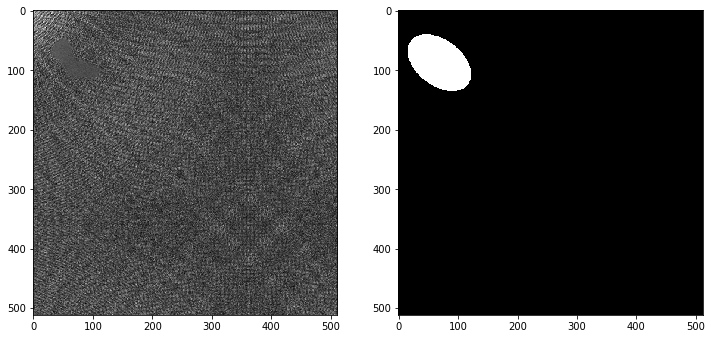

In [7]:
from coslib import plot_ellipse_seg_test

plot_ellipse_seg_test(os.path.join(data_dir, "1.png"))

In [0]:
from coslib import load_images_masks

In [0]:
X, y = load_images_masks(data_dir, img_type='png', img_format='gray', resize=(512, 512), ellipse=True)

In [10]:
X.shape

(150, 512, 512, 1)

In [11]:
y.shape

(150, 512, 512, 1)

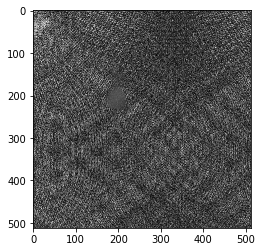

In [12]:
plt.imshow(X[0,:,:,0], cmap='gray')

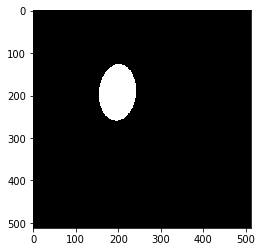

In [13]:
plt.imshow(y[0,:,:,0], cmap='gray')

In [0]:
import sklearn
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [16]:
X_train.shape

(105, 512, 512, 1)

In [17]:
X_test.shape

(45, 512, 512, 1)

## Unet - Fully Convolutional Neuralnetwork

The u-net is convolutional network architecture for fast and precise segmentation of images. Up to now it has outperformed the prior best method (a sliding-window convolutional network) on the ISBI challenge for segmentation of neuronal structures in electron microscopic stacks. It has won the Grand Challenge for Computer-Automated Detection of Caries in Bitewing Radiography at ISBI 2015, and it has won the Cell Tracking Challenge at ISBI 2015 on the two most challenging transmitted light microscopy categories (Phase contrast and DIC microscopy) by a large margin.

In [0]:
img_rows = 512
img_cols = 512

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Lambda, Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as K
from scipy.ndimage.measurements import label
import time
from losses import focal_tversky

In [0]:
# Defining a small Unet
# Smaller Unet defined so it fits in memory


def get_small_unet():
    inputs = Input((img_rows, img_cols, 1))
    inputs_norm = Lambda(lambda x: x/127.5 - 1.)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(64, kernel_size=(
        2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(32, kernel_size=(
        2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(16, kernel_size=(
        2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(8, kernel_size=(
        2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(16, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    return model

In [21]:
model = get_small_unet()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
def smooth_dice_coeff(smooth=1.):

    smooth = float(smooth)

    # IOU or dice coeff calculation
    def IOU_calc(y_true, y_pred):
            y_true_f = K.flatten(y_true)
            y_pred_f = K.flatten(y_pred)
            intersection = K.sum(y_true_f * y_pred_f)

            return 2*(intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    def IOU_calc_loss(y_true, y_pred):
        return -IOU_calc(y_true, y_pred)
    return IOU_calc, IOU_calc_loss

IOU_calc, IOU_calc_loss = smooth_dice_coeff(0.00001)

In [0]:
model.compile(optimizer=Adam(lr=1e-4), loss=focal_tversky, metrics=[IOU_calc])

In [24]:
history = model.fit(X_train, y_train, batch_size=10, epochs=50, verbose=1, validation_split=0.1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 94 samples, validate on 11 samples
Epoch 1/50
94/94 [==============================] - 20s 211ms/sample - loss: 0.9134 - IOU_calc: 0.0730 - val_loss: 0.9088 - val_IOU_calc: 0.0674
Epoch 2/50
94/94 [==============================] - 6s 62ms/sample - loss: 0.9077 - IOU_calc: 0.0783 - val_loss: 0.9002 - val_IOU_calc: 0.0888
Epoch 3/50
94/94 [==============================] - 6s 62ms/sample - loss: 0.8965 - IOU_calc: 0.0910 - val_loss: 0.8768 - val_IOU_calc: 0.0981
Epoch 4/50
94/94 [==============================] - 6s 63ms/sample - loss: 0.8659 - IOU_calc: 0.1415 - val_loss: 0.8127 - val_IOU_calc: 0.2242
Epoch 5/50
94/94 [==============================] - 6s 62ms/sample - loss: 0.8108 - IOU_calc: 0.2265 - val_loss: 0.7588 - val_IOU_calc: 0.3750
Epoch 6/50
94/94 [==============================] - 6s 62ms/sample - loss: 0.7945 - IOU_calc: 0.3112 - val_loss: 0.7986 - val_IOU_calc: 0.2353
Ep

## Learning curves

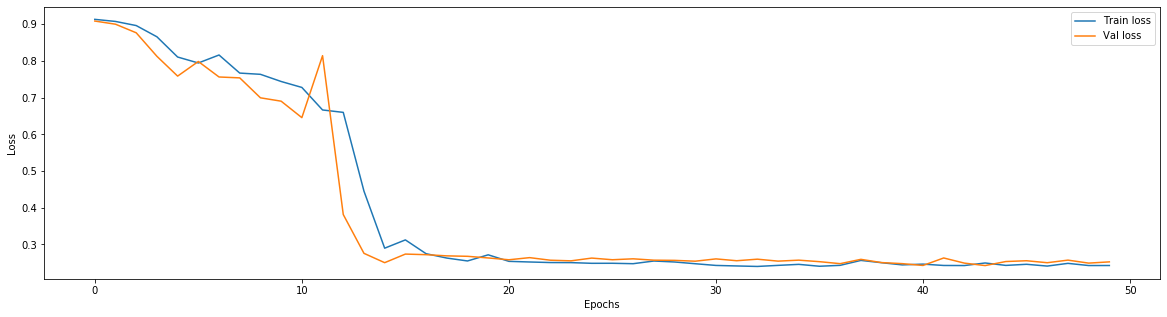

In [25]:
plt.figure(figsize=(20, 5))
plt.plot(model.history.history['loss'], label='Train loss')
plt.plot(model.history.history['val_loss'], label='Val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

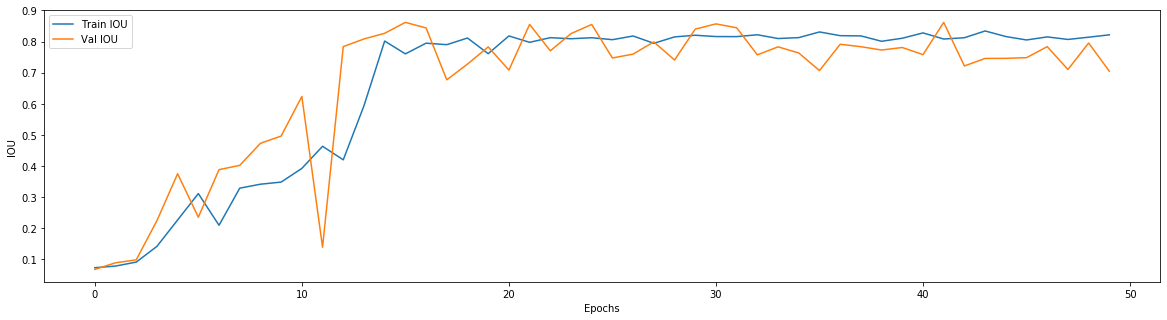

In [26]:
plt.figure(figsize=(20, 5))
plt.plot(model.history.history['IOU_calc'], label='Train IOU')
plt.plot(model.history.history['val_IOU_calc'], label='Val IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()

## Predict on testing data

In [0]:
predict = model.predict(X_test)

In [0]:
import numpy as np
import cv2


def predict_evaluation(pred, image, label):
    '''
    '''
    # transform gray image to rgb
    img = np.array(image, np.uint8)
    rgb_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    # scale pred and mask's pixel range to 0~255
    im_label = np.array(255*label, dtype=np.uint8)
    im_pred = np.array(255*pred, dtype=np.uint8)

    # transform both of them to rgb
    rgb_label = cv2.cvtColor(im_label, cv2.COLOR_GRAY2RGB)
    rgb_pred = cv2.cvtColor(im_pred, cv2.COLOR_GRAY2RGB)

    rgb_label[:, :, 1:3] = 0*rgb_label[:, :, 1:2]
    rgb_pred[:, :, 0] = 0*rgb_pred[:, :, 0]
    rgb_pred[:, :, 2] = 0*rgb_pred[:, :, 2]

    img_pred = cv2.addWeighted(rgb_img, 1, rgb_pred, 0.3, 0)
    img_label = cv2.addWeighted(rgb_img, 1, rgb_label, 0.3, 0)

    plt.figure(figsize=(10, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(rgb_img)
    plt.title('Original image')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(img_pred)
    plt.title('Prediction')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(img_label)
    plt.title('Ground truth')
    plt.axis('off')

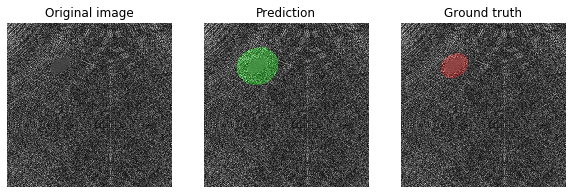

In [29]:
predict_evaluation(predict[0,:,:,0], X_test[0,:,:,0], y_test[0,:,:,0])

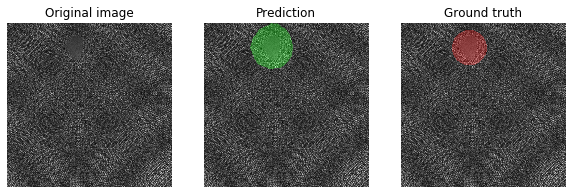

In [30]:
predict_evaluation(predict[1,:,:,0], X_test[1,:,:,0], y_test[1,:,:,0])

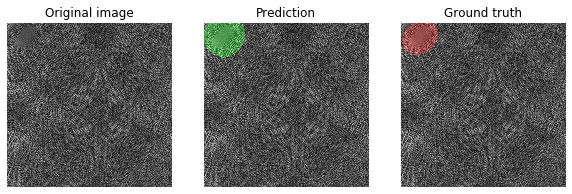

In [31]:
predict_evaluation(predict[2,:,:,0], X_test[2,:,:,0], y_test[2,:,:,0])

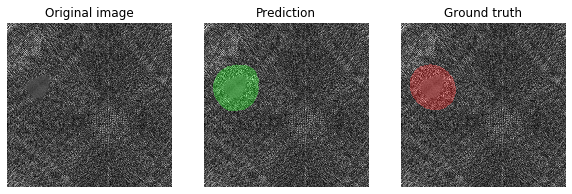

In [32]:
predict_evaluation(predict[3,:,:,0], X_test[3,:,:,0], y_test[3,:,:,0])

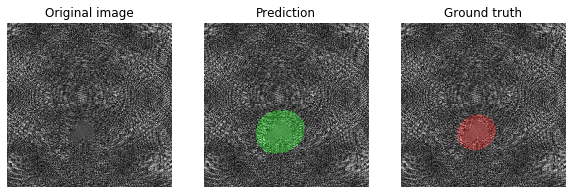

In [33]:
predict_evaluation(predict[4,:,:,0], X_test[4,:,:,0], y_test[4,:,:,0])

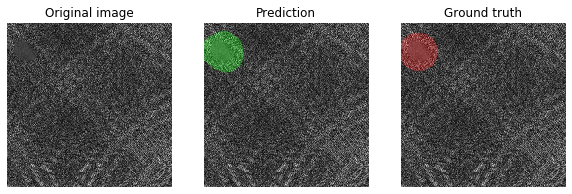

In [34]:
predict_evaluation(predict[5,:,:,0], X_test[5,:,:,0], y_test[5,:,:,0])

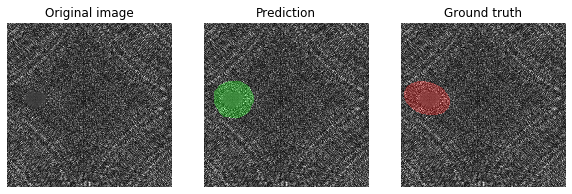

In [35]:
predict_evaluation(predict[6,:,:,0], X_test[6,:,:,0], y_test[6,:,:,0])

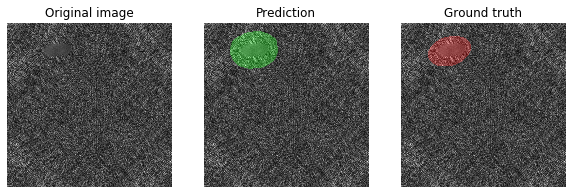

In [36]:
predict_evaluation(predict[7,:,:,0], X_test[7,:,:,0], y_test[7,:,:,0])

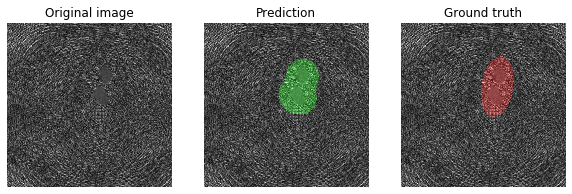

In [37]:
predict_evaluation(predict[8,:,:,0], X_test[8,:,:,0], y_test[8,:,:,0])

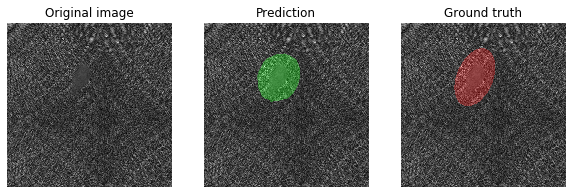

In [38]:
predict_evaluation(predict[9,:,:,0], X_test[9,:,:,0], y_test[9,:,:,0])